# Problem Statement

In the telecommunication industry, customers tend to change operators if not provided with attractive schemes and offers. It is very important for any telecom operator to prevent the present customers from churning to other operators. As a data scientist, your task in this case study would be to build an ML model which can predict if the customer will churn or not in a particular month based on the past data.

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Reading & Understanding

In [4]:
df=pd.read_csv('/content/drive/MyDrive/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/test.csv')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [5]:
df.set_index('id',inplace=True)
df_test.set_index('id',inplace=True)

In [6]:
df_test.head(10)

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                                 
69999        109             0.0             0.0             0.0   
70000        109             0.0             0.0             0.0   
70001        109             0.0             0.0             0.0   
70002        109             0.0             0.0             0.0   
70003        109             0.0             0.0             0.0   
70004        109             0.0             0.0             0.0   
70005        109             0.0             0.0             0.0   
70006        109             0.0             0.0             0.0   
70007        109             0.0             0.0             0.0   
70008        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                              
69999            6/30/2014            7/31/2014            8/31/2014   91.882   
70000            6/30/2014            7/31/2014            8/31/2014  414.168   
70001            6/30/2014            7/31/2014            8/31/2014  329.844   
70002            6/30/2014            7/31/2014            8/31/2014   43.550   
70003            6/30/2014            7/31/2014            8/31/2014  306.854   
70004            6/30/2014            7/31/2014            8/31/2014  134.798   
70005            6/30/2014            7/31/2014            8/31/2014   41.890   
70006            6/30/2014            7/31/2014            8/31/2014   52.177   
70007            6/30/2014            7/31/2014            8/31/2014  273.082   
70008            6/30/2014            7/31/2014            8/31/2014    0.000   

        arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
id                                                                             
69999   65.330   64.445        31.78        20.23        23.11         60.16   
70000  515.568  360.868        75.51        41.21        19.84        474.34   
70001  434.884  746.239         7.54         7.86         8.40         16.98   
70002  171.390   24.400         5.31         2.16         0.00         40.04   
70003  406.289  413.329       450.93       609.03       700.68         60.94   
70004   58.016    0.200        60.19        23.59          NaN         75.58   
70005   20.120  129.610        13.13        12.34        33.33         22.54   
70006   54.063   24.408         0.21         0.00         0.00         51.91   
70007  298.166  256.839       290.08       165.11        68.04        158.28   
70008  302.970   76.833          NaN        15.31          NaN           NaN   

       offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                
69999         32.16         34.83           0.00           0.00   
70000        621.84        394.94           0.00           0.00   
70001         45.81         45.04          22.81         103.38   
70002        205.01         24.01           0.00           0.00   
70003         23.84         74.16           0.00           0.00   
70004         26.68           NaN         123.31         121.19   
70005          8.34         32.13           0.00           0.00   
70006         49.31         21.21           0.00           0.00   
70007        141.11         25.88           0.00           0.00   
70008         46.81           NaN            NaN           0.00   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
69999           0.00           0.00           0.00           0.00   
70000           0.00           0.00           0.00           0.00   
70001          26.08          24.53          53.68          54.44   
70002           0.00           0.00           0.00           0.00   
70003           0.00           0.00  

In [7]:
#check initial shape
df.shape

(69999, 171)

In [8]:
#view dataset's basic info 
df.info(verbose=1, show_counts=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    circle_id                 69999 non-null  int64  
 1    loc_og_t2o_mou            69297 non-null  float64
 2    std_og_t2o_mou            69297 non-null  float64
 3    loc_ic_t2o_mou            69297 non-null  float64
 4    last_date_of_month_6      69999 non-null  object 
 5    last_date_of_month_7      69600 non-null  object 
 6    last_date_of_month_8      69266 non-null  object 
 7    arpu_6                    69999 non-null  float64
 8    arpu_7                    69999 non-null  float64
 9    arpu_8                    69999 non-null  float64
 10   onnet_mou_6               67231 non-null  float64
 11   onnet_mou_7               67312 non-null  float64
 12   onnet_mou_8               66296 non-null  float64
 13   offnet_mou_6              67231 non-null  fl

In [9]:
#check duplicate data if any
print(df.duplicated().sum())
print(df_test.duplicated().sum())

0
0


no duplicate data found

In [10]:
#check basic statistical description
df.describe()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    69999.0         69297.0         69297.0         69297.0   
mean       109.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min        109.0             0.0             0.0             0.0   
25%        109.0             0.0             0.0             0.0   
50%        109.0             0.0             0.0             0.0   
75%        109.0             0.0             0.0             0.0   
max        109.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.765435   
std      311.896596    316.818355    322.482226    324.089234      57.374429   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   67312.000000   66296.000000   67231.000000   67312.000000   
mean        7.014568       7.004892      14.186457       9.842191   
std        55.960985      53.408135      73.469261      58.511894   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.771783         46.904854         46.166503         45.686109   
std        64.618388        150.971758        154.739002        153.716880   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.660000          1.650000          1.610000   
50%         0.000000         11.910000         11.580000         11.740000   
75%         0.000000         40.740000         39.760000         39.895000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      67231.000000      67312.000000      66296.000000      67231.000000   
mean          93.238231         90.799240         91.121447          3.743179   
std          162.046699        153.852597        152.997805         13.319542   
min            0.000000          0.000000          0.000000          0.000000   
25%            9.920000         10.090000          9.830000          0.000000   
50%           41.030000         40.170000         40.350000          0.000000   
75%          110.430000        107.540000        109.245000          

In [11]:
#find all features having atleast 1 null value
print('Percentage of Missing values :')
print(round(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0]*100,2))

Percentage of Missing values :
loc_og_t2o_mou               1.00
std_og_t2o_mou               1.00
loc_ic_t2o_mou               1.00
last_date_of_month_7         0.57
last_date_of_month_8         1.05
onnet_mou_6                  3.95
onnet_mou_7                  3.84
onnet_mou_8                  5.29
offnet_mou_6                 3.95
offnet_mou_7                 3.84
offnet_mou_8                 5.29
roam_ic_mou_6                3.95
roam_ic_mou_7                3.84
roam_ic_mou_8                5.29
roam_og_mou_6                3.95
roam_og_mou_7                3.84
roam_og_mou_8                5.29
loc_og_t2t_mou_6             3.95
loc_og_t2t_mou_7             3.84
loc_og_t2t_mou_8             5.29
loc_og_t2m_mou_6             3.95
loc_og_t2m_mou_7             3.84
loc_og_t2m_mou_8             5.29
loc_og_t2f_mou_6             3.95
loc_og_t2f_mou_7             3.84
loc_og_t2f_mou_8             5.29
loc_og_t2c_mou_6             3.95
loc_og_t2c_mou_7             3.84
loc_og_t2c_mou_8 

- There are 69999 rows & 171 columns
- There are null rows too
- No duplicate data found


## Data Preparation & Cleaning


We will now understand the data these null column contains so as to decide whether to impute or drop



### High value Customers filtering


In [12]:
# extract recharge features
rch_features=[i for i in df.columns if 'rech' in i and 'date' not in i]
rch_features


['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [13]:
#impute missing rows in recharge columns with 0 here because recharge being not present can signify the user did not recharge
for i in rch_features:
  df[i]=df[i].fillna(0)
  df_test[i]=df_test[i].fillna(0)


In [14]:
#calculate the total data recharge amount for June and July
#number of recharges * average recharge amount
df['total_data_rech_amt_6'] = df.total_rech_data_6 * df.av_rech_amt_data_6
df['total_data_rech_amt_7'] = df.total_rech_data_7 * df.av_rech_amt_data_7

In [15]:
# calculate total recharge amount for June and July 
#call recharge amount + data recharge amount
df['total_amt_6'] = df.total_rech_amt_6 + df.total_data_rech_amt_6
df['total_amt_7'] = df.total_rech_amt_7 + df.total_data_rech_amt_7

In [16]:
# calculate average recharge in June and July
df['av_amt_6_7'] = (df.total_amt_6 + df.total_amt_7)/2

In [17]:
#60th percentile recharge amount, above it we are considering high value customers
thresh=df.av_amt_6_7.quantile(0.60)
print("Recharge amount at 60th percentile: {0}".format(thresh))

Recharge amount at 60th percentile: 361.0


In [18]:
#consider only high value customers
df=df[df.av_amt_6_7>=thresh]

In [19]:
#drop the cols used to calculate high val customers
df.drop(['total_data_rech_amt_6','total_data_rech_amt_7','total_amt_6','total_amt_7','av_amt_6_7'],axis=1,inplace=True)

In [20]:
df.shape

(28029, 171)


Calculate no of days since last recharge from date cols since only dates would not make sense for model

In [21]:
# extract date features
date_features=[i for i in df.columns if 'date' in i]
date_features


['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

#Feature Engineering
##Data Imputation
### Derived Features
we will calculate if last recharge was on 8/7/6 month based on that we calculate the number of days since last recharge

In [22]:
def rchg(df,rech_cols):
  #data recharges
  for i in range(df.shape[0]):
    if pd.isnull(rech_cols.iloc[i,8]):
      if pd.isnull(rech_cols.iloc[i,7]):
        rech_cols.iloc[i,8]=rech_cols.iloc[i,6]
      else:
        rech_cols.iloc[i,8]=rech_cols.iloc[i,7]
  df['last_data_rech_date']=rech_cols.date_of_last_rech_data_8
  #df['last_data_rech_date'] = df['last_data_rech_date'].fillna(0)


  #call related recharges
  for i in range(df.shape[0]):
    if pd.isnull(rech_cols.iloc[i,5]):
      if pd.isnull(rech_cols.iloc[i,4]):
        rech_cols.iloc[i,5]=rech_cols.iloc[i,3]
      else:
        rech_cols.iloc[i,5]=rech_cols.iloc[i,4]
  df['last_rech_date']=rech_cols.date_of_last_rech_8

  #we can assume if the customer has not recharged data for last 3 months then it 
  #must be recharged before that so imputing it with last day of 5th month
  df['last_data_rech_date'] = df['last_data_rech_date'].fillna('5/31/2014')
  return df['last_data_rech_date'],df['last_rech_date']

#train data
rech_cols=df[date_features]
df['last_data_rech_date'],df['last_rech_date']=rchg(df,rech_cols)
#test data
rech_cols=df_test[date_features]
df_test['last_data_rech_date'],df_test['last_rech_date']=rchg(df_test,rech_cols)

In [23]:
#calculate no of days since last recharge taking reference date as 1st september
import datetime
def ndays(df):
  df['last_rech_date']=pd.to_datetime(df['last_rech_date'])
  df['last_data_rech_date']=pd.to_datetime(df['last_data_rech_date'])
  d=datetime.date(2014,9,1)
  d=pd.to_datetime(d)
  df['last_data_rech_date']=d-df['last_data_rech_date']
  df['last_rech_date']=d-df['last_rech_date']
  df['last_data_rech_date']=df['last_data_rech_date'].astype('timedelta64[D]')
  df['last_rech_date']=df['last_rech_date'].astype('timedelta64[D]')
  return df['last_data_rech_date'],df['last_rech_date']

#train data
df['last_data_rech_date'],df['last_rech_date']=ndays(df)

#test data
df_test['last_data_rech_date'],df_test['last_rech_date']=ndays(df_test)

In [24]:
df.rename(columns = {'last_data_rech_date':'last_data_rech_days', 'last_rech_date':'last_rech_days'}, inplace = True)
df_test.rename(columns = {'last_data_rech_date':'last_data_rech_days', 'last_rech_date':'last_rech_days'}, inplace = True)


In [25]:
df.drop(date_features,axis=1,inplace=True)
df_test.drop(date_features,axis=1,inplace=True)

We need to check the value distribution for each of the features. We will remove those features having no variance as it would effect the learning of the model

In [26]:
#Columns with no variance can be dropped 
drop_cols=[]
val_prcnt=0
for i in df.columns:
    val_prcnt=np.max(df[i].value_counts(normalize=True)*100)
    if val_prcnt>=100:
        print(i,':',val_prcnt)
        drop_cols.append(i)
#drop_cols

circle_id : 100.0
loc_og_t2o_mou : 100.0
std_og_t2o_mou : 100.0
loc_ic_t2o_mou : 100.0
std_og_t2c_mou_6 : 100.0
std_og_t2c_mou_7 : 100.0
std_og_t2c_mou_8 : 100.0
std_ic_t2o_mou_6 : 100.0
std_ic_t2o_mou_7 : 100.0
std_ic_t2o_mou_8 : 100.0


In [27]:
df.drop(drop_cols,axis=1,inplace=True)
df_test.drop(drop_cols,axis=1,inplace=True)

In [28]:
print(df.shape,df_test.shape)

(28029, 154) (30000, 153)


In [29]:
# extract fb & night related features
fb_night_features=[i for i in df.columns if 'fb' in i or 'night' in i]
for i in fb_night_features:
  print(df[i].value_counts())
  #impute with most occuring since data is unknown and if removed it may have impact on model
  df[i]=df[i].fillna(df[i].mode()[0])
  df_test[i]=df_test[i].fillna(df_test[i].mode()[0])
  

0.0    13339
1.0      319
Name: night_pck_user_6, dtype: int64
0.0    13591
1.0      314
Name: night_pck_user_7, dtype: int64
0.0    12910
1.0      268
Name: night_pck_user_8, dtype: int64
1.0    12634
0.0     1024
Name: fb_user_6, dtype: int64
1.0    12796
0.0     1109
Name: fb_user_7, dtype: int64
1.0    11689
0.0     1489
Name: fb_user_8, dtype: int64


In [30]:
df.shape

(28029, 154)

In [31]:
#we see that count for the respective items is also 0 wherever arpu is missing so we can impute with 0
arpu_features=[i for i in df.columns if 'arpu_3g' in i or 'arpu_2g' in i]
count_features=[i for i in df.columns if 'count' in i]
for i,j in zip(arpu_features,count_features):
  #print(i,j)
  print(df[df[i].isna()][j].value_counts())

0.0    14371
Name: count_rech_2g_6, dtype: int64
0.0    14124
Name: count_rech_2g_7, dtype: int64
0.0    14851
Name: count_rech_2g_8, dtype: int64
0.0    14371
Name: count_rech_3g_6, dtype: int64
0.0    14124
Name: count_rech_3g_7, dtype: int64
0.0    14851
Name: count_rech_3g_8, dtype: int64


In [32]:
# Now impute missing values with 0
df[arpu_features] = df[arpu_features].apply(lambda x: x.fillna(0))
df_test[arpu_features] = df_test[arpu_features].apply(lambda x: x.fillna(0))

In [33]:
#using KNN technique to impute missing values for minutes of usage,incomming & outgoing 
from sklearn.impute import KNNImputer
def impute(df):
  impute_knn = KNNImputer(n_neighbors=3)
  imput=impute_knn.fit_transform(df)
  return pd.DataFrame(imput, columns=df.columns)
df=impute(df)
df_test=impute(df_test)

In [34]:
df.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  240.708  128.191  101.565        21.28         4.83         6.13   
1  167.861  167.869  167.866         0.00         0.00         0.00   
2  439.919  397.946  392.024       244.46       108.31        42.98   
3  580.549  377.294  338.286        10.43        24.99       194.43   
4  277.458  283.346  231.755       179.54       287.98       155.16   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         56.99         38.11          9.63          53.64            0.0   
1          0.00          0.00          0.00           0.00            0.0   
2        571.98        727.91        644.43           0.00            0.0   
3        317.11        341.79        197.09           0.00            0.0   
4        335.41        255.18        281.06          12.58            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0          15.73            0.0            0.0   
1            0.0           0.00            0.0            0.0   
2            0.0           0.00            0.0            0.0   
3            0.0           0.00            0.0            0.0   
4            0.0          16.73            0.0            0.0   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0             10.16              4.83              6.13             36.74   
1              0.00              0.00              0.00              0.00   
2              0.00              7.86              3.98             44.01   
3             10.43             24.99            194.43            313.76   
4            173.33            287.98            155.16            321.29   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             19.88              4.61             11.99              1.23   
1              0.00              0.00              0.00              0.00   
2             13.93             51.24              0.00              0.00   
3            330.88            185.88              3.26             10.91   
4            249.88            266.99              0.00              4.88   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              5.01               0.0              9.85               0.0   
1              0.00               0.0              0.00               0.0   
2              0.00               0.0              0.00               0.0   
3              4.94               0.0              0.00               0.0   
4              2.81               0.0              0.00               0.0   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0         58.91         25.94         15.76              0.00   
1          0.00          0.00          0.00              0.00   
2         44.01         21.79         55.23            244.46   
3        327.46        366.79        385.26              0.00   
4        494.63        542.74        424.98              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0              0.00              0.00              4.35              0.00   
1              0.00              0.00              0.00              0.00   
2            100.44             38.99            527.96            713.98   
3              0.00              0.00              0.00              0.00   
4              0.00              0.00              0.00              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0              0.00               0.0              0.00              0.00   
1              0.00               0.0              0.00              0.00   
2            593.18               0.0              0.00              0.00   
3              0.00               0.0              0.00              6.26   
4              0.00               3.6              0.41              0.00   

   std_og_mou_6  

In [35]:

print(round(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0]*100,2))
print(round(df_test.isnull().sum()[df_test.isnull().sum()>0]/df_test.shape[0]*100,2))

Series([], dtype: float64)
Series([], dtype: float64)


no more null columns

### Derived Columns
we will be calculating the difference between the attributes from month 8 & average of 6 & 7 th month, if the diff is +ve it is a good sign for not churning and increase in usage or rechg amt

In [36]:
# renaming vbc cols as per all column names
df.rename(columns = {'aug_vbc_3g':'vbc_3g_8', 'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7'}, inplace = True)
df_test.rename(columns = {'aug_vbc_3g':'vbc_3g_8', 'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7'}, inplace = True)

In [37]:
#collect all month features
jun_features=[i for i in df.columns if '6' in i and 'night' not in i and 'fb' not in i ]
jul_features=[i for i in df.columns if '7' in i and 'night' not in i and 'fb' not in i ]
aug_features=[i for i in df.columns if '8' in i and 'night' not in i and 'fb' not in i ]


In [38]:
#calculate
for i,j,k in zip(jun_features,jul_features,aug_features):
  df[i[:-1]+'diff']=df[k]-(df[i]+df[j])/2
  df_test[i[:-1]+'diff']=df_test[k]-(df_test[i]+df_test[j])/2
drop_cols=jun_features+jul_features+aug_features
len(drop_cols)

144

In [39]:
df.drop(drop_cols,axis=1,inplace=True)
df_test.drop(drop_cols,axis=1,inplace=True)

In [40]:
df.shape

(28029, 58)

In [41]:
df_test.head()

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  fb_user_7  \
0               0.0               0.0               0.0        1.0        1.0   
1               0.0               0.0               0.0        1.0        1.0   
2               0.0               0.0               0.0        1.0        1.0   
3               0.0               0.0               0.0        1.0        1.0   
4               0.0               0.0               0.0        1.0        1.0   

   fb_user_8     aon  last_data_rech_days  last_rech_days  arpu_diff  \
0        1.0  1692.0                 93.0             8.0   -14.1610   
1        1.0  2533.0                 93.0             8.0  -104.0000   
2        1.0   277.0                 93.0             4.0   363.8750   
3        1.0  1244.0                 93.0             8.0   -83.0700   
4        1.0   462.0                 93.0             2.0    56.7575   

   onnet_mou_diff  offnet_mou_diff  roam_ic_mou_diff  roam_og_mou_diff  \
0          -2.895          -11.330             0.000             0.000   
1         -38.520         -153.150             0.000             0.000   
2           0.700           13.645           -37.015            15.335   
3          -3.735          -98.515             0.000             0.000   
4         170.700           31.770             0.000             0.000   

   loc_og_t2t_mou_diff  loc_og_t2m_mou_diff  loc_og_t2f_mou_diff  \
0               -1.495               -6.150               -6.790   
1              -38.520             -158.585               -0.365   
2                0.000                0.000                0.000   
3               -2.655              -30.265                2.350   
4               13.945                8.415                0.000   

   loc_og_t2c_mou_diff  loc_og_mou_diff  std_og_t2t_mou_diff  \
0                 0.03          -14.430                -1.40   
1                 0.00         -197.465                 0.00   
2                 0.00            0.000                 0.00   
3                -3.09          -30.575                -1.08   
4                 0.00           22.370               156.75   

   std_og_t2m_mou_diff  std_og_t2f_mou_diff  std_og_mou_diff  isd_og_mou_diff  \
0                1.575                  0.0            0.175              0.0   
1                5.800                  0.0            5.800              0.8   
2                0.000                  0.0            0.000              0.0   
3              -65.725                  0.0          -66.810              0.0   
4               23.320                  0.0          180.060              0.0   

   spl_og_mou_diff  og_others_diff  total_og_mou_diff  loc_ic_t2t_mou_diff  \
0            0.030             0.0            -14.225              -11.965   
1            0.000             0.0           -190.870              -20.860   
2            0.000             0.0              0.000                0.000   
3           -4.865             0.0           -102.260              -33.335   
4            1.910            -1.1            203.245                9.730   

   loc_ic_t2m_mou_diff  loc_ic_t2f_mou_diff  loc_ic_mou_diff  \
0                2.130               -0.130           -9.975   
1               43.570               -0.745           21.965   
2                0.000                0.000            0.000   
3               38.055                1.450            6.180   
4               -1.990                0.000            7.750   

   std_ic_t2t_mou_diff  std_ic_t2m_mou_diff  std_ic_t2f_mou_diff  \
0                0.000                3.640                 0.00   
1                0.000               -6.255                 0.00   
2                0.000                0.000                 0.00   
3               -2.130               -1.925                 0.00   
4               46.355               18.540                 1.61   

   std_ic_mou_diff  total_ic_mou_diff  spl_ic_mou_diff  isd_ic_mou_diff  \
0            3.640 

In [42]:
print(df.shape,df_test.shape)

(28029, 58) (30000, 57)


## Outliers

In [43]:
df.shape

(28029, 58)

In [44]:
#selct numerical features
num_cols=df.select_dtypes(include=['int','float']).columns
len(num_cols)

58

In [45]:
# function to get outlier percentage
def outliers(x):
    iqr = df[x].quantile(0.75)-df[x].quantile(0.25)
    upper = df[x].quantile(0.75)+iqr*1.5
    lower = df[x].quantile(0.25)-iqr*1.5
    per = ((df[x]<lower).sum()+(df[x]>upper).sum())/len(df[x])*100
    per = round(per,2)
    return per,x
out_cols=[]
for i in num_cols:
    out,x=outliers(i)
    #more than 5%
    if out>=5:
        out_cols.append(x)
        print('outlier% in ',i,' : ' ,out)

outlier% in  fb_user_8  :  5.31
outlier% in  churn_probability  :  8.68
outlier% in  last_rech_days  :  8.97
outlier% in  arpu_diff  :  7.51
outlier% in  onnet_mou_diff  :  21.4
outlier% in  offnet_mou_diff  :  15.44
outlier% in  roam_ic_mou_diff  :  36.12
outlier% in  roam_og_mou_diff  :  36.22
outlier% in  loc_og_t2t_mou_diff  :  18.59
outlier% in  loc_og_t2m_mou_diff  :  15.64
outlier% in  loc_og_t2f_mou_diff  :  29.25
outlier% in  loc_og_t2c_mou_diff  :  36.94
outlier% in  loc_og_mou_diff  :  15.08
outlier% in  std_og_t2t_mou_diff  :  34.55
outlier% in  std_og_t2m_mou_diff  :  28.67
outlier% in  std_og_t2f_mou_diff  :  25.73
outlier% in  std_og_mou_diff  :  29.78
outlier% in  isd_og_mou_diff  :  13.63
outlier% in  spl_og_mou_diff  :  22.69
outlier% in  og_others_diff  :  22.83
outlier% in  total_og_mou_diff  :  16.44
outlier% in  loc_ic_t2t_mou_diff  :  15.47
outlier% in  loc_ic_t2m_mou_diff  :  12.83
outlier% in  loc_ic_t2f_mou_diff  :  23.9
outlier% in  loc_ic_mou_diff  :  13.12


Since we are dealing with high value customers the outliers contain the most of the information & if we remove using K sigma rule we lose on huge data

In [46]:
#def cap_outliers(array, k=3):
 #   upper_limit = array.mean() + k*array.std()
  #  lower_limit = array.mean() - k*array.std()
   # array[array<lower_limit] = lower_limit
    #array[array>upper_limit] = upper_limit
    #return array

In [47]:
#out_cols.remove('churn_probability')
#out_cols

In [48]:
# cap outliers in the numeric columns
#out_cols
#df[out_cols] = df[out_cols].apply(cap_outliers, axis=0)

In [49]:
df.head()

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  fb_user_7  \
0               0.0               0.0               0.0        1.0        1.0   
1               0.0               0.0               0.0        1.0        1.0   
2               0.0               0.0               0.0        1.0        1.0   
3               0.0               0.0               0.0        1.0        1.0   
4               0.0               0.0               0.0        1.0        1.0   

   fb_user_8     aon  churn_probability  last_data_rech_days  last_rech_days  \
0        1.0   647.0                0.0                 12.0             2.0   
1        1.0   584.0                0.0                 12.0             4.0   
2        1.0   322.0                0.0                 93.0             2.0   
3        1.0   602.0                0.0                 30.0             2.0   
4        1.0  2837.0                0.0                 93.0            11.0   

   arpu_diff  onnet_mou_diff  offnet_mou_diff  roam_ic_mou_diff  \
0   -82.8845          -6.925          -37.920            -26.82   
1     0.0010           0.000            0.000              0.00   
2   -26.9085        -133.405           -5.515              0.00   
3  -140.6355         176.720         -132.360              0.00   
4   -48.6470         -78.600          -14.235             -6.29   

   roam_og_mou_diff  loc_og_t2t_mou_diff  loc_og_t2m_mou_diff  \
0            -7.865               -1.365              -23.700   
1             0.000                0.000                0.000   
2             0.000                0.050               22.270   
3             0.000              176.720             -136.440   
4            -8.365              -75.495              -18.595   

   loc_og_t2f_mou_diff  loc_og_t2c_mou_diff  loc_og_mou_diff  \
0               -1.600               -4.925          -26.665   
1                0.000                0.000            0.000   
2                0.000                0.000           22.330   
3               -2.145                0.000           38.135   
4                0.370                0.000          -93.705   

   std_og_t2t_mou_diff  std_og_t2m_mou_diff  std_og_t2f_mou_diff  \
0                 0.00               -2.175                0.000   
1                 0.00                0.000                0.000   
2              -133.46              -27.790                0.000   
3                 0.00                0.000                6.260   
4                 0.00                0.000               -2.005   

   std_og_mou_diff  isd_og_mou_diff  spl_og_mou_diff  og_others_diff  \
0           -2.175              0.0            -8.50            0.00   
1            0.000              0.0             0.00            0.00   
2         -161.250              0.0             0.00            0.00   
3            6.260              0.0            -0.04           -0.05   
4           -2.005              0.0            11.24            0.00   

   total_og_mou_diff  loc_ic_t2t_mou_diff  loc_ic_t2m_mou_diff  \
0            -37.340               -0.755               12.035   
1              0.000               19.740               -2.555   
2           -138.925                0.795               -2.845   
3             44.315              318.410             -201.145   
4            -84.465              -56.835              224.920   

   loc_ic_t2f_mou_diff  loc_ic_mou_diff  std_ic_t2t_mou_diff  \
0                1.570           12.860                0.000   
1                4.140           21.335                0.000   
2                0.000           -2.040               -0.115   
3                7.915          125.170                0.000   
4               14.180          182.275                0.000   

   std_ic_t2m_mou_diff  std_ic_t2f_mou_diff  std_ic_mou_diff  \
0                0.000                0.000            0.000   
1                0.000                1.985            1.985   
2               -5.525               -0.

## EDA

## Univariate Analysis

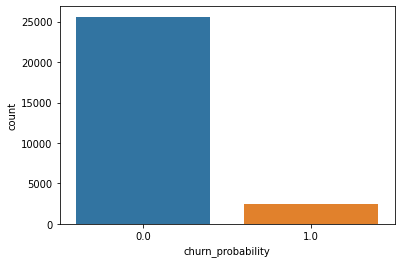

In [50]:
sns.countplot(df.churn_probability)

There is a high imbalance seen throughout the dataset. Considering business point of view it is expected to have lower churn rates

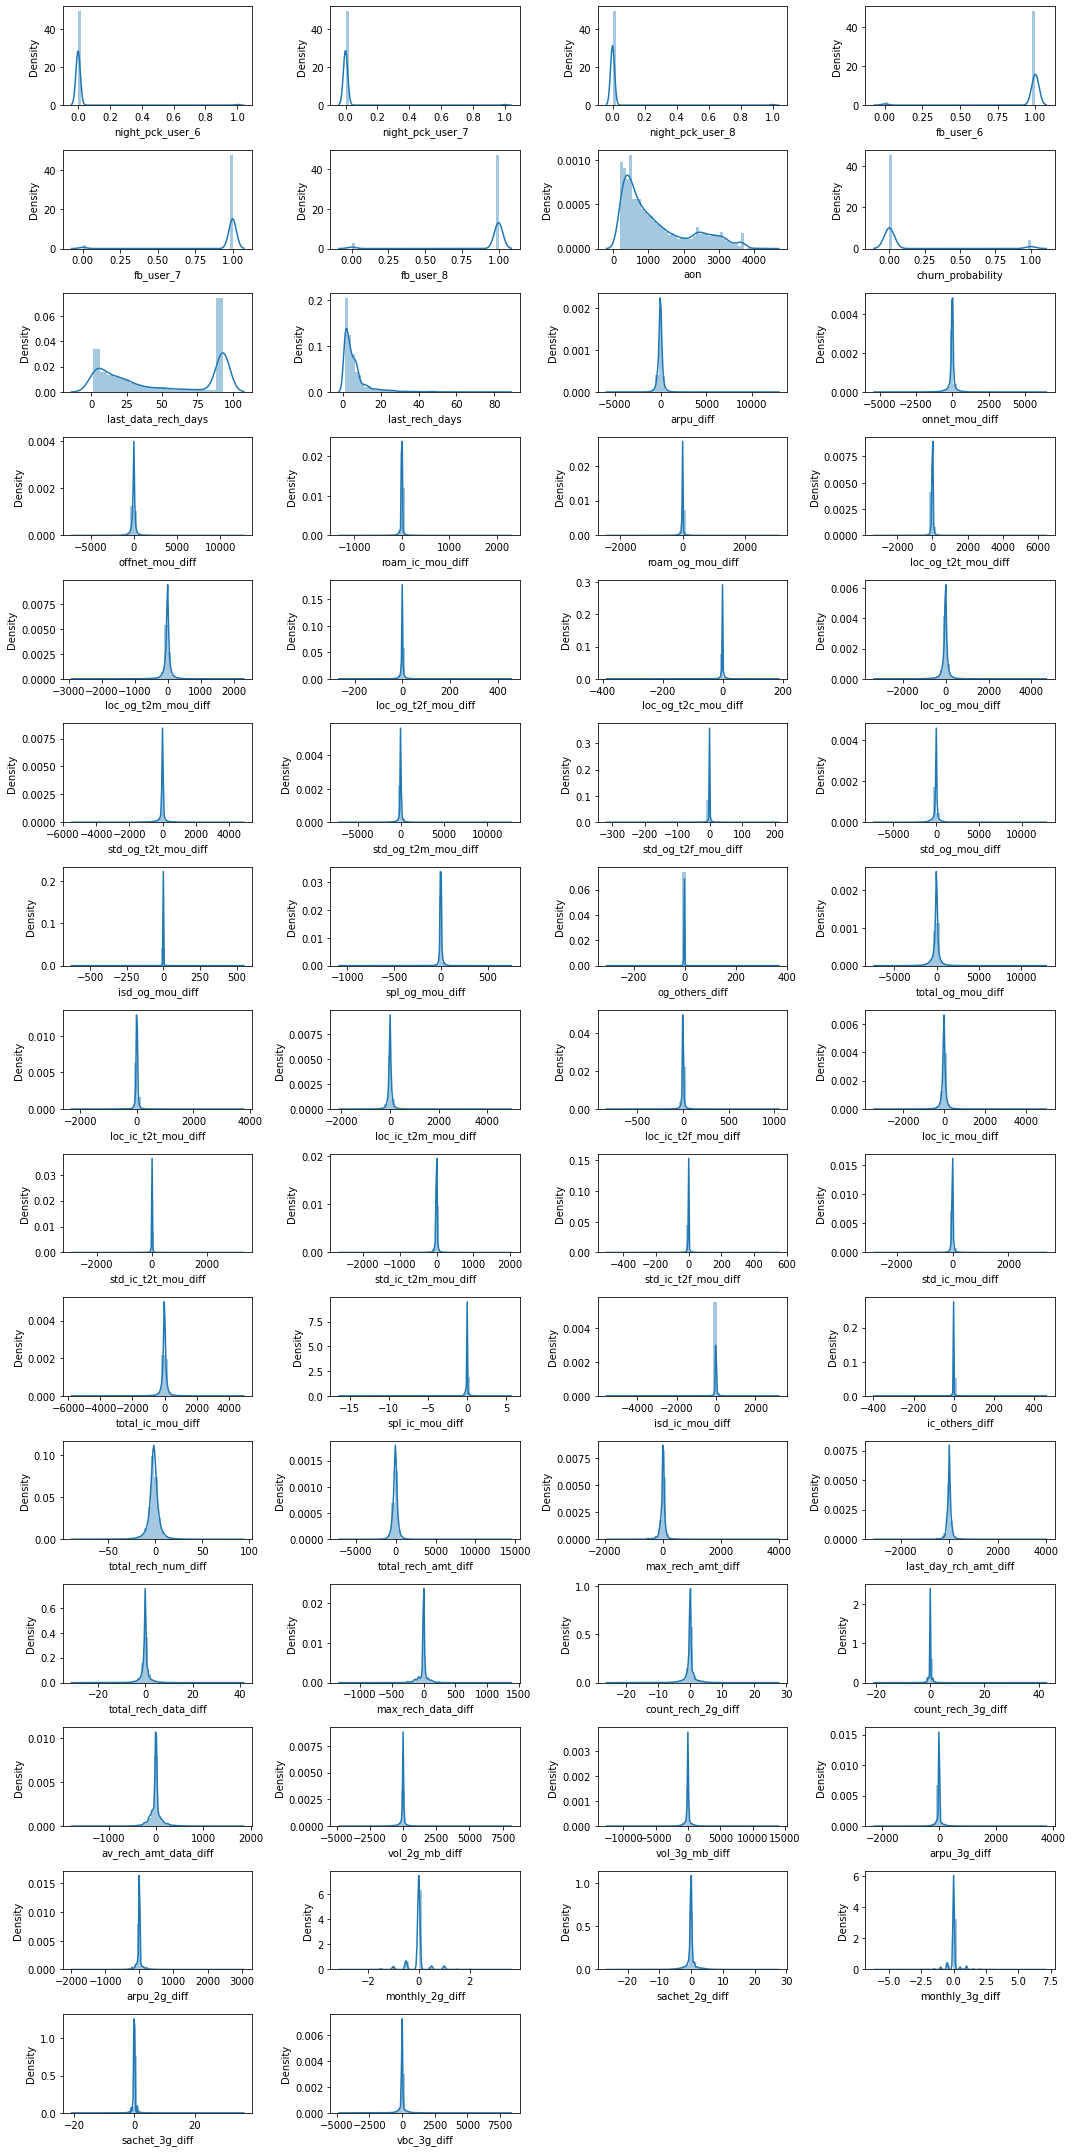

In [51]:
# distribution plot
plt.figure(figsize=(15,30))
for i in list(enumerate(df[num_cols])):
    plt.subplot(15,4, i[0]+1)
    sns.distplot(x=df[i[1]])
    plt.xlabel(i[1])
plt.tight_layout()
plt.show()

From the above plots it is seen the features are mostly normally distributed

## Bivariate Analysis

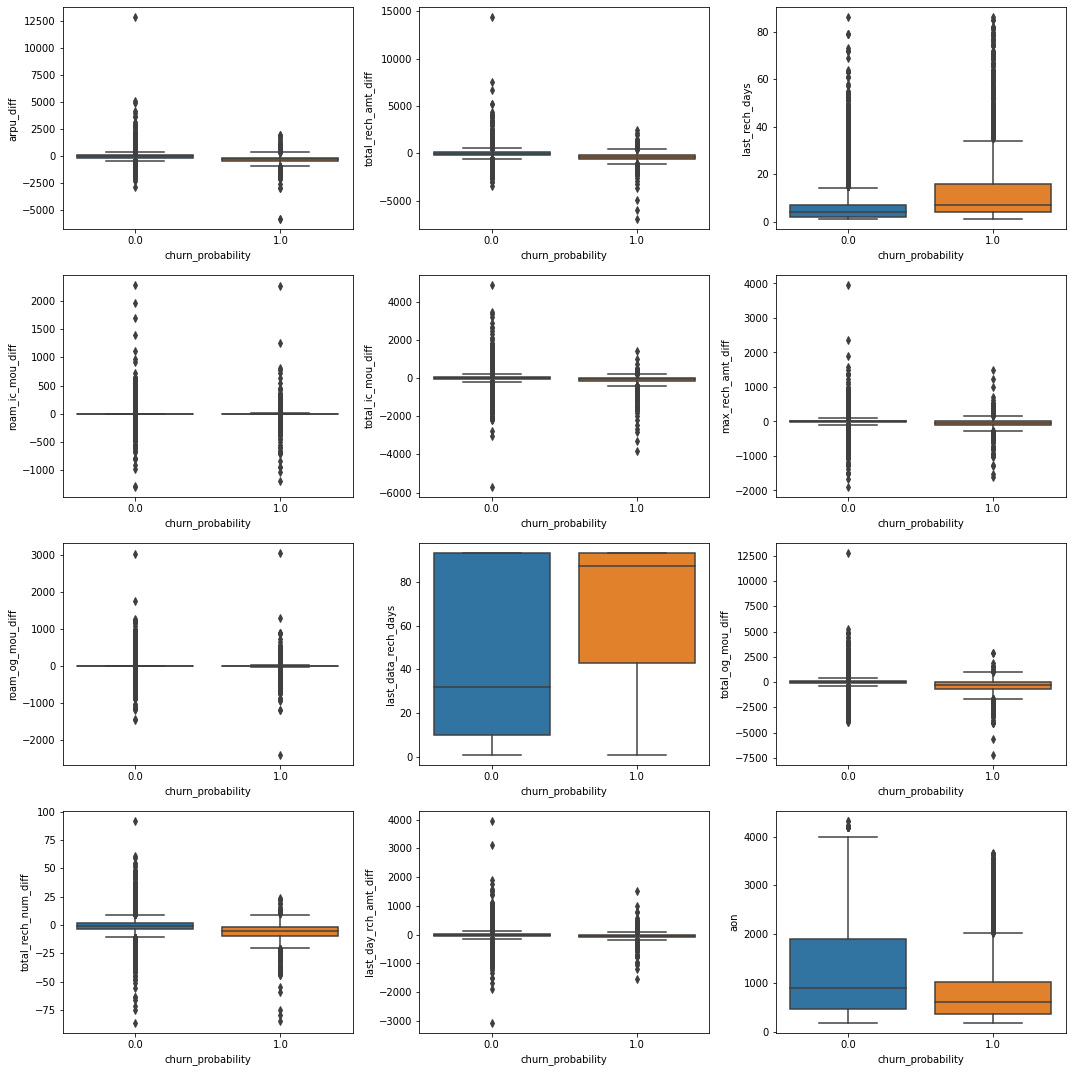

In [52]:
#box plot
cols=['arpu_diff','total_rech_amt_diff','last_rech_days','roam_ic_mou_diff','total_ic_mou_diff',
        'max_rech_amt_diff','roam_og_mou_diff','last_data_rech_days','total_og_mou_diff','total_rech_num_diff','last_day_rch_amt_diff','aon']
plt.figure(figsize=(15,15))
for i in list(enumerate(df[cols])):
    plt.subplot(4,3, i[0]+1)
    sns.boxplot(y=df[i[1]],x=df.churn_probability,data=df)
    #plt.xlabel(i[1])
plt.tight_layout()
plt.show()

## Inferences
- average revenue per user is less for churned customers 
- total recharge amt for calls & internet is seen less for churned customers as they might be having long term plans
-the number of days since last recharge is seen more for churnerd customers as they might be using it very less & may churn
- for churned customer we can see roaming & total incomming & outgoing mou is less as well as recharging amt
- number of times recharged and age on network is low for churned customers


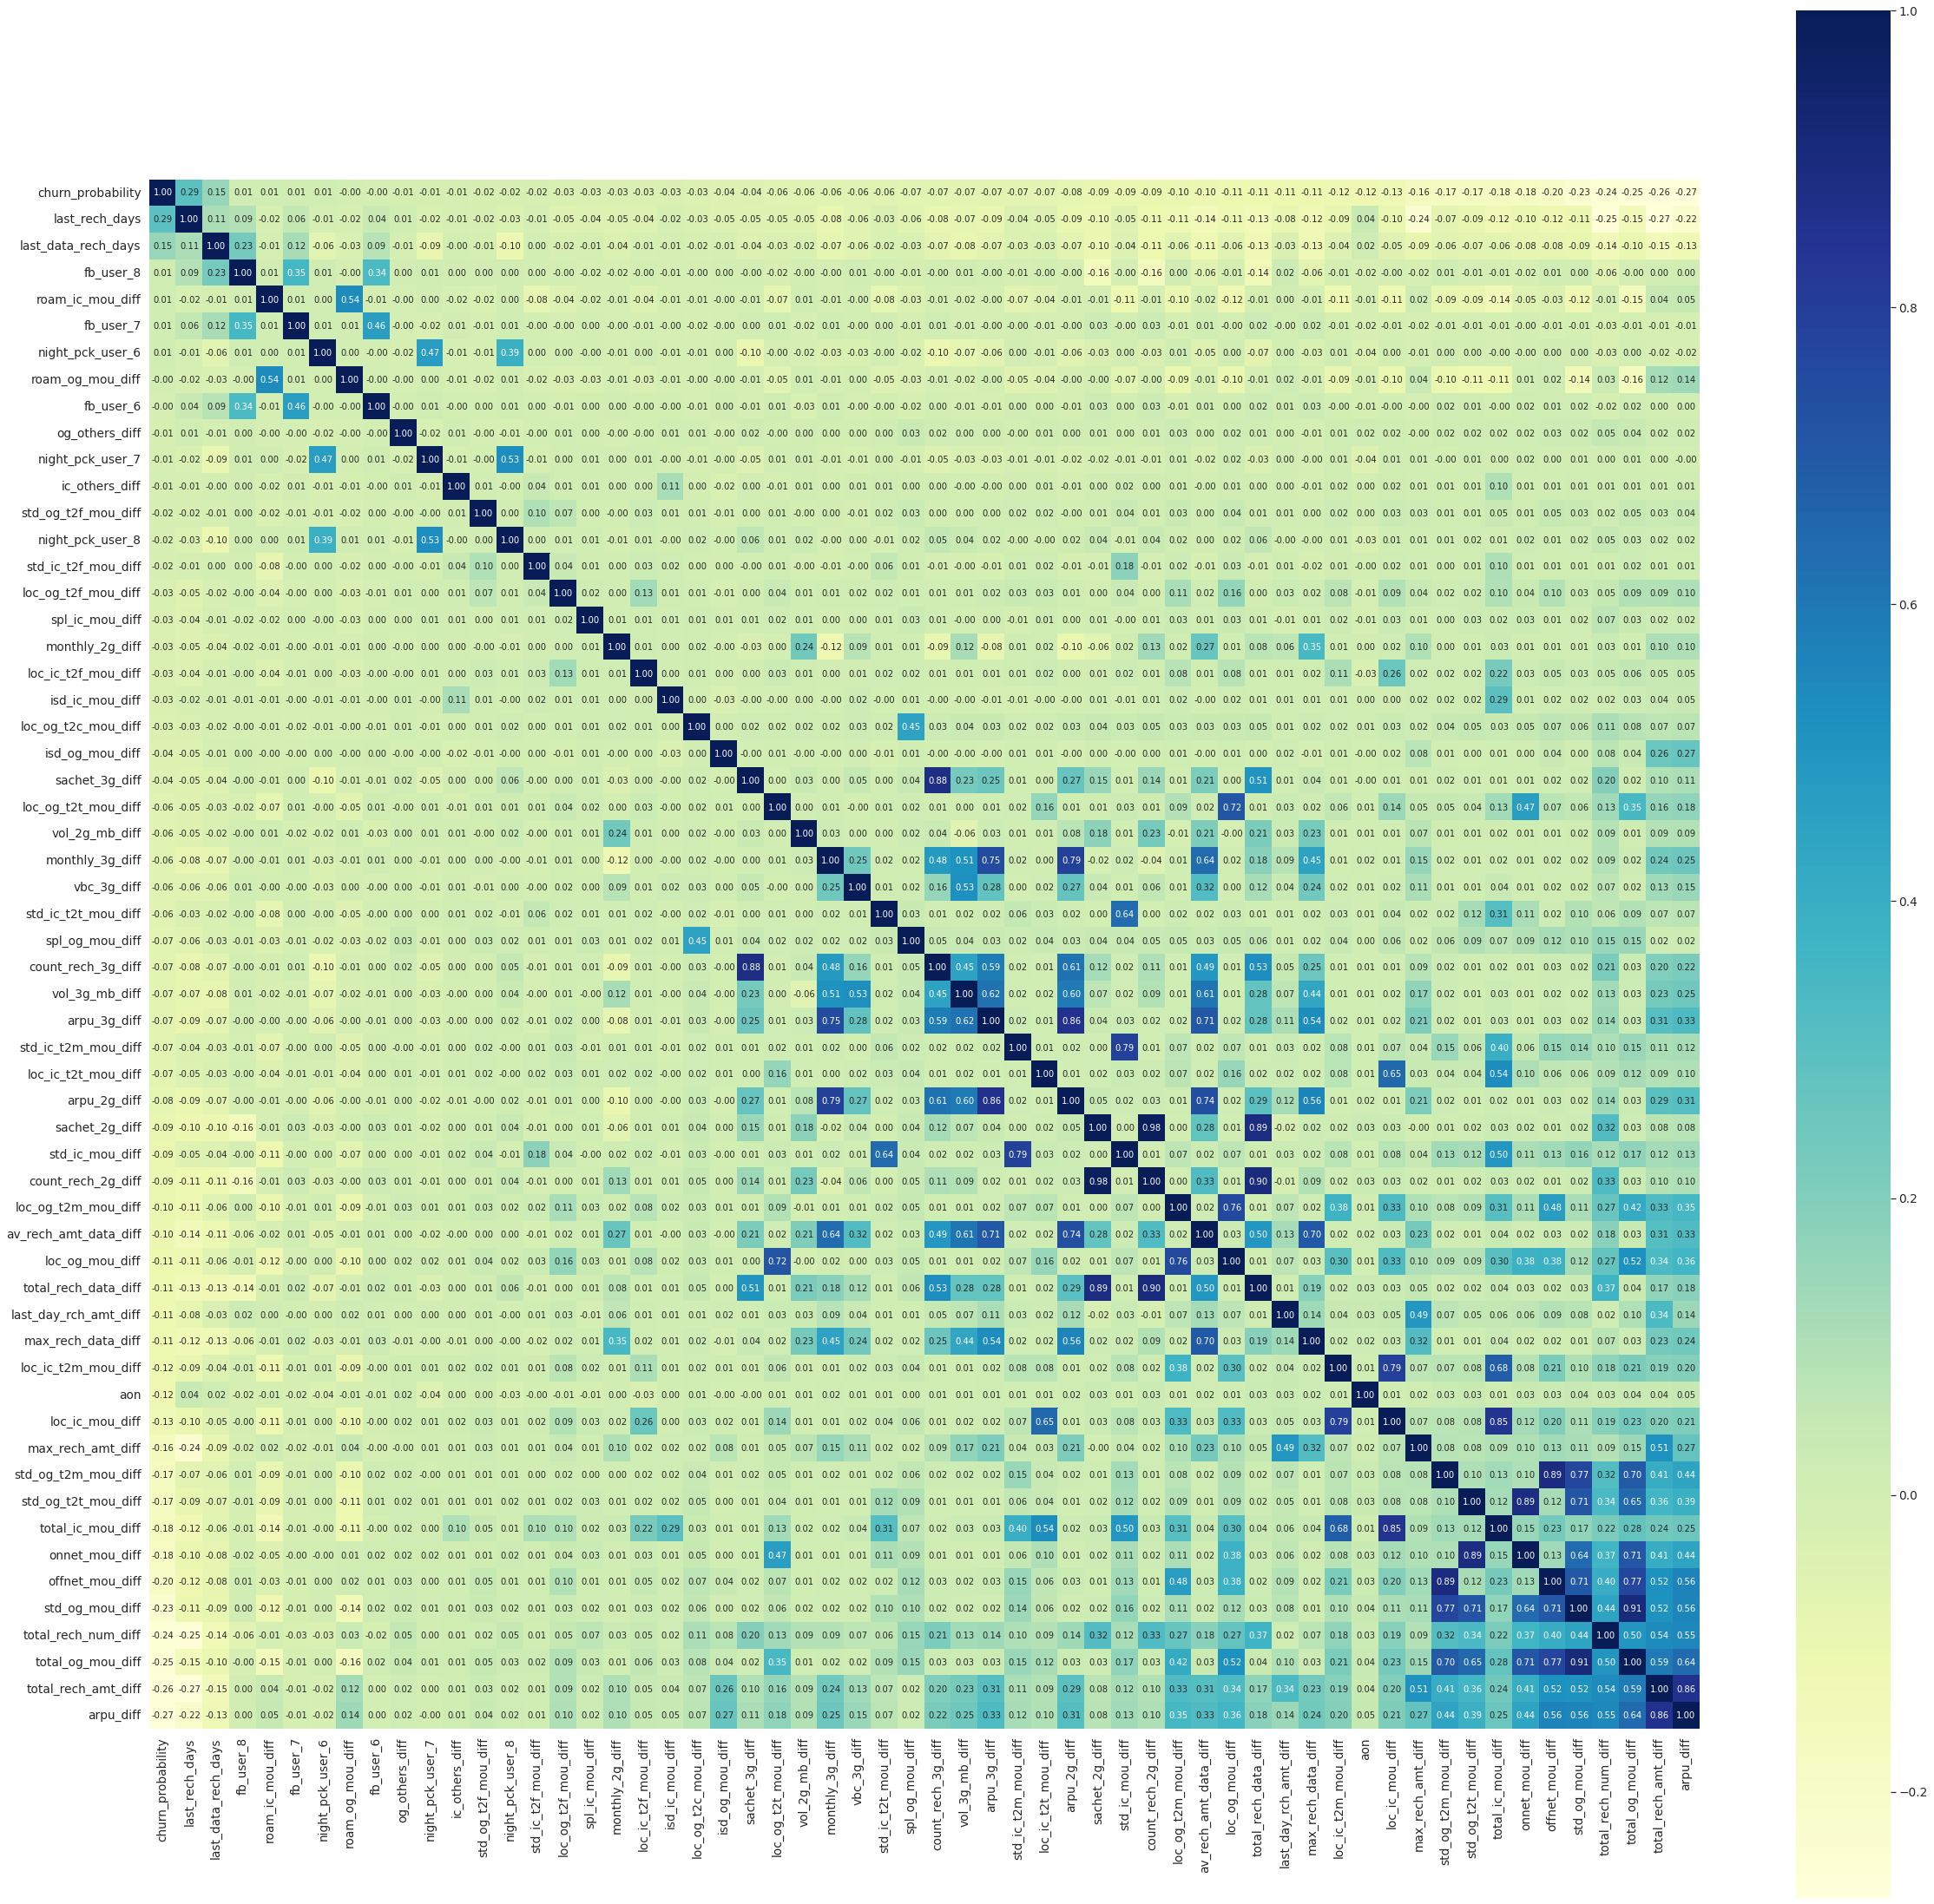

In [53]:
#correlation plot
plt.figure(figsize=(40,40))
corrmat =df.corr()
k = 60 #number of variables for heatmap
cols = corrmat.nlargest(k, 'churn_probability')['churn_probability'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap='YlGnBu',annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [54]:
#drop multicollinear variables
multicolnr=['sachet_3g_diff', 'loc_ic_mou_diff','std_og_mou_diff','count_rech_2g_diff','std_og_t2t_mou_diff', 'std_og_t2m_mou_diff','std_og_t2t_mou_diff', 'std_og_t2m_mou_diff']
df.drop(multicolnr,axis=1,inplace=True)
df_test.drop(multicolnr,axis=1,inplace=True)


# Model Buildng & Evaluation

In [55]:
#minority class 
df['churn_probability'].value_counts()[1]/df['churn_probability'].value_counts()[0]

0.09509669857394022

In [56]:
# divide data into train and test
y = df.pop('churn_probability')
x = df

## Train Test Split


In [151]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 70,stratify=y)

In [58]:
X_train.shape

(19620, 51)

## PCA

In [59]:
# apply pca to train data

pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

pca.fit(X_train)

churn_pca = pca.fit_transform(X_train)
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0      12.23
1      20.89
2      25.47
3      29.68
4      33.49
5      37.20
6      40.74
7      43.93
8      46.86
9      49.63
10     52.31
11     54.81
12     57.14
13     59.36
14     61.55
15     63.64
16     65.69
17     67.66
18     69.60
19     71.52
20     73.40
21     75.24
22     77.02
23     78.79
24     80.48
25     82.16
26     83.83
27     85.38
28     86.82
29     88.19
30     89.40
31     90.57
32     91.63
33     92.65
34     93.63
35     94.54
36     95.43
37     96.29
38     97.13
39     97.80
40     98.40
41     98.91
42     99.28
43     99.58
44     99.82
45     99.99
46    100.00
47    100.00
48    100.00
49    100.00
50    100.00
dtype: float64


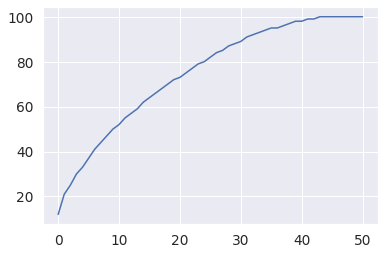

In [60]:
#PCA components
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100)
plt.plot(cumulative_variance)

## Logistic Regression with PCA

### Base Model

In [61]:

#logistic regression 
param = [("scale",StandardScaler()),
         ("pca", PCA(n_components=35)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(param)
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)


0.8087155963302752

In [62]:
# predict churn on test data

y_pred = pipeline.predict(X_test)

#sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))



print(classification_report(y_test, y_pred))

Sensitivity: 	0.77
Specificity: 	0.81
AUC:    	 0.86
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.89      7679
         1.0       0.28      0.77      0.41       730

    accuracy                           0.81      8409
   macro avg       0.63      0.79      0.65      8409
weighted avg       0.91      0.81      0.85      8409



In [63]:
#logistic tuning

pipe_param = [("scaler",StandardScaler()),
         ("pca", PCA()),
         ("logistic", LogisticRegression(class_weight={0:0.1,1:0.9}))
        ]
pipeline = Pipeline(pipe_param)

# compile pipeline
#pca_logistic = Pipeline(steps)

#hyperparameter
params = {'pca__n_components': [30,35], 'logistic__solver' : ['liblinear','saga'],'logistic__C': [0.01,0.1, 1, 10], 'logistic__penalty': ['l1','l2','elasticnet']}

#5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 14)

#gridsearch
model_lr = GridSearchCV(estimator=pipeline, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=3)

# fit model
model_lr.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=14, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.1, 1, 10],
                         'logistic__penalty': ['l1', 'l2', 'elasticnet'],
                         'logistic__solver': ['liblinear', 'saga'],
                         'pca__n_components': [30, 35]},
             scoring='roc_auc', verbose=3)

In [64]:
# print best hyperparameters
print("AUC: ", model_lr.best_score_)
print("hyperparameters: ", model_lr.best_params_)

AUC:  0.8554049505260624
hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear', 'pca__n_components': 35}


In [65]:
# check score on train data
model_lr.score(X_train, y_train)

0.8587628088618038

In [66]:
# predict churn on test data
y_pred = model_lr.predict(X_test)
lr_pca=[]
#sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model_lr.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

lr_pca.append(round(sensitivity, 2))
lr_pca.append(round(specificity, 2))
lr_pca.append(round(accuracy_score(y_test, y_pred),2))

print(classification_report(y_test, y_pred))

Sensitivity: 	0.75
Specificity: 	0.84
AUC:    	 0.86
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      7679
         1.0       0.31      0.75      0.44       730

    accuracy                           0.83      8409
   macro avg       0.64      0.80      0.67      8409
weighted avg       0.92      0.83      0.86      8409



### Tuned Model

In [67]:
model_lr.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=35)),
                ('logistic',
                 LogisticRegression(C=0.1, class_weight={0: 0.1, 1: 0.9},
                                    solver='liblinear'))])

In [68]:
#Cross Validation 
scores = cross_val_score(model_lr.best_estimator_, X_train, y_train, cv=5,scoring='roc_auc', n_jobs=-1)

print('Cross validation scores',scores)

Cross validation scores [0.85465878 0.84744758 0.85865561 0.86110445 0.85040387]


## Random Forest with PCA

###Base Model

In [70]:
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight='balanced', oob_score=True, random_state=4, verbose=1)



# create pipeline
param = [
         ("pca", PCA(n_components=35)),
         ("rf", rf_model)]
pipeline = Pipeline(param)

# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

#rf_model.fit(X_train, y_train)
#print(rf_model.oob_score_)

7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


0.9999490316004077

In [71]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Sensitivity: 	0.23
Specificity: 	0.99
ROC:    	 0.89
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      7679
         1.0       0.71      0.23      0.35       730

    accuracy                           0.92      8409
   macro avg       0.82      0.61      0.65      8409
weighted avg       0.91      0.92      0.91      8409



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [72]:
#hyperparameter tuning
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(max_features=max_features, class_weight='balanced', oob_score=True, random_state=4, verbose=1)



# create pipeline
pipe_param = [
         ("pca", PCA(n_components=35)),
         ("rf", rf_model)]
pipeline = Pipeline(pipe_param)


params = {
    'rf__max_depth': [2,3,5,10],
    'rf__min_samples_leaf': [10,20,50,100],
    'rf__n_estimators': [10, 25, 50, 100]
}

#5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 14)

#gridsearch
model_rf = GridSearchCV(estimator=pipeline, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=3)

# fit model
model_rf.fit(X_train, y_train)

#print(model.oob_score_)

# check score on train data
model_rf.score(X_train, y_train)

#rf_model.fit(X_train, y_train)
#print(rf_model.oob_score_)

7
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.9706904587081917

In [73]:
# print best hyperparameters
print("AUC: ", model_rf.best_score_)
print("hyperparameters: ", model_rf.best_params_)

AUC:  0.8897282551174429
hyperparameters:  {'rf__max_depth': 10, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 100}


In [74]:
model_rf.score(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.9706904587081917

In [75]:
# predict churn on test data
y_pred = model_rf.predict(X_test)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model_rf.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))
rf_pca=[]
rf_pca.append(round(sensitivity, 2))
rf_pca.append(round(specificity, 2))
rf_pca.append(round(accuracy_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Sensitivity: 	0.65
Specificity: 	0.93
ROC:    	 0.89
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7679
         1.0       0.45      0.65      0.53       730

    accuracy                           0.90      8409
   macro avg       0.71      0.79      0.74      8409
weighted avg       0.92      0.90      0.91      8409



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Tuned Model

In [76]:
model_rf.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=35)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=7, min_samples_leaf=10,
                                        oob_score=True, random_state=4,
                                        verbose=1))])

In [77]:
#fit with tuned parameters

rf_model=model_rf.best_estimator_.fit(X_train, y_train)

scores = cross_val_score(model_rf.best_estimator_, X_train, y_train, cv=5,scoring='roc_auc', n_jobs=-1)

print(rf_model.oob_score_)
scores

print('Cross validation scores',scores)

Cross validation scores [0.90061384 0.87481943 0.89186227 0.89556009 0.88581383]


In [78]:
rf_pca

[0.65, 0.93, 0.9]

## XGBoost with PCA

### Base Model

In [79]:
#XGBoost

xgbmodel = xgb.XGBClassifier(scale_pos_weight=92, learning_rate=0.3,
                             max_depth=6)

# create pipeline
param = [
         ("pca", PCA(n_components=35)),
         ("xgb", xgbmodel)]
pipeline = Pipeline(param)

# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

# predict churn on test data
y_pred = pipeline.predict(X_test)
#print(pipeline.score(X_test, y_pred))
#sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print(classification_report(y_test, y_pred))

Sensitivity: 	0.62
Specificity: 	0.91
AUC:    	 0.87
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      7679
         1.0       0.41      0.62      0.49       730

    accuracy                           0.89      8409
   macro avg       0.69      0.77      0.72      8409
weighted avg       0.91      0.89      0.90      8409



## Tuned Model

In [80]:
#XGBoost

#xgbmodel = xgb.XGBClassifier(scale_pos_weight=99, learning_rate=0.17,reg_alpha=0,reg_lambda=1,
 #                            min_child_weight=6,max_depth=8,n_estimators=220,random_state=20,eta=0.26,subsample=1)

xgbmodel = xgb.XGBClassifier(scale_pos_weight=9, learning_rate=0.1,gamma=0.5,alpha=1,
                             max_depth=7, n_estimators=200,random_state=4)

# create pipeline
param = [
         ("pca", PCA(n_components=40)),
         ("xgb", xgbmodel)]
pipeline = Pipeline(param)

# fit model
pipeline.fit(X_train, y_train)

# check score on train data
print(pipeline.score(X_train, y_train))

# predict churn on test data
y_pred = pipeline.predict(X_test)
print(pipeline.score(X_test, y_test))
#sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("*"*50)
print(classification_report(y_test, y_pred))



xgb_pca=[]
xgb_pca.append(round(sensitivity, 2))
xgb_pca.append(round(specificity, 2))
xgb_pca.append(round(accuracy_score(y_test, y_pred),2))
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {'objective':'binary:logistic','eval_metric':'logloss',
          'eta':0.01,
          'subsample':0.1}
xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'logloss',seed=43)
xgb_cv

0.9968909276248725
0.9249613509335236
Sensitivity: 	0.52
Specificity: 	0.96
AUC:    	 0.89
**************************************************
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      7679
         1.0       0.57      0.52      0.55       730

    accuracy                           0.92      8409
   macro avg       0.76      0.74      0.75      8409
weighted avg       0.92      0.92      0.92      8409



train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.685600           0.000079           0.685670          0.000114
1            0.678139           0.000092           0.678320          0.000149
2            0.670938           0.000090           0.671094          0.000199
3            0.663767           0.000142           0.664033          0.000287
4            0.656787           0.000071           0.657138          0.000254
5            0.649914           0.000118           0.650338          0.000313
6            0.643203           0.000152           0.643704          0.000321
7            0.636612           0.000175           0.637191          0.000381
8            0.630127           0.000164           0.630801          0.000464
9            0.623732           0.000137           0.624435          0.000528

- for overall accuracy we choose the xgboost model
- considering business point of view where we must predict the customer who might churn, we should use the logistic regression model since here our Sensitivity score should be high which is a better predictor for the same

---



In [ ]:
len(df_test)

30000

In [ ]:
#Kaggle submission
# predict churn on test data
id=range(69999,69999+30000)
y_pred = pipeline.predict(df_test)
y_pred_final = pd.DataFrame({'id':id,'churn_probability':y_pred})
y_pred_final.churn_probability = y_pred_final.churn_probability.astype('int64')
y_pred_final

id  churn_probability
0      69999                  0
1      70000                  0
2      70001                  0
3      70002                  0
4      70003                  0
5      70004                  0
6      70005                  0
7      70006                  0
8      70007                  0
9      70008                  0
10     70009                  0
11     70010                  0
12     70011                  0
13     70012                  0
14     70013                  0
15     70014                  0
16     70015                  0
17     70016                  0
18     70017                  0
19     70018                  0
20     70019                  0
21     70020                  0
22     70021                  0
23     70022                  0
24     70023                  0
25     70024                  0
26     70025                  0
27     70026                  0
28     70027                  0
29     70028                  0
30     70029                  0
31     70030                  0
32     70031                  0
33     70032                  0
34     70033                  0
35     70034                  0
36     70035                  1
37     70036                  0
38     70037                  0
39     70038                  0
40     70039                  0
41     70040                  0
42     70041                  0
43     70042                  0
44     70043                  0
45     70044                  0
46     70045                  0
47     70046                  0
48     70047                  0
49     70048                  0
50     70049                  0
51     70050                  0
52     70051                  0
53     70052                  0
54     70053                  0
55     70054                  0
56     70055                  0
57     70056                  0
58     70057                  0
59     70058                  0
60     70059                  0
61     70060                  0
62     70061                  0
63     70062                  0
64     70063                  0
65     70064                  0
66     70065                  0
67     70066                  0
68     70067                  0
69     70068                  0
70     70069                  0
71     70070                  0
72     70071                  0
73     70072                  0
74     70073                  1
75     70074                  0
76     70075                  0
77     70076                  0
78     70077                  0
79     70078                  0
80     70079                  0
81     70080                  0
82     70081                  1
83     70082                  0
84     70083                  0
85     70084                  0
86     70085                  0
87     70086                  0
88     70087                  0
89     70088                  0
90     70089                  0
91     70090                  0
92     70091                  0
93     70092                  0
94     70093                  0
95     70094                  0
96     70095                  1
97     70096                  0
98     70097                  0
99     70098                  0
100    70099                  0
101    70100                  0
102    70101                  0
103    70102                  0
104    70103                  0
105    70104                  0
106    70105                  0
107    70106                  0
108    70107                  0
109    70108                  0
110    70109                  0
111    70110                  0
112    70111                  1
113    70112                  0
114    70113                  0
115    70114                  0
116    70115                  0
117    70116                  0
118    70117                  0
119    70118                  1
120    70119                  0
121    70120                  0
122    70121                  0
123    70122                  0
124    701

In [ ]:
y_pred_final.to_csv('Submission3.csv',index=False)

# Conclusion

In [83]:
# Creating a table which contain all the metrics

table = {'Metric': ['Sensitivity',' Specificity','Accuracy'], 
        'Logistic Regression': lr_pca
        }

lr_metric = pd.DataFrame(table ,columns = ['Metric', 'Logistic Regression'] )

rf_metric = pd.Series(rf_pca, name = 'Random Forest')
xgb_metric = pd.Series(xgb_pca, name = 'XGBoost')

final = pd.concat([lr_metric, rf_metric, xgb_metric], axis = 1)

final

Metric  Logistic Regression  Random Forest  XGBoost
0   Sensitivity                 0.75           0.65     0.52
1   Specificity                 0.84           0.93     0.96
2      Accuracy                 0.83           0.90     0.92

# Models for Important Features

## Logistic without PCA

In [172]:
x_train_lr=X_train
x_test_lr=X_test

In [173]:
#scale for logistic
scaler=StandardScaler()
x_train_lr[X_train.columns]=scaler.fit_transform(X_train[X_train.columns])
x_test_lr[X_test.columns]=scaler.transform(X_test[X_test.columns])

In [174]:

#logistic regression 
logi=LogisticRegression(class_weight='balanced')

#hyperparameter
params = {'solver' : ['liblinear','saga'],'C': [0.01,0.1, 0.5, 1], 'penalty': ['l1','l2','elasticnet']}

#5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 14)

#gridsearch
model = GridSearchCV(estimator=logi, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=3)

#rfe= RFE(model,n_features_to_select=20)
# fit model
#rfe.fit(X_train, y_train)

# check score on train data
model.fit(x_train_lr,y_train)
model.score(x_train_lr, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.8624311078197996

In [175]:
# print best hyperparameters
print("AUC: ", model.best_score_)
print("hyperparameters: ", model.best_params_)

AUC:  0.8570664952816329
hyperparameters:  {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [176]:
model.best_estimator_

LogisticRegression(C=0.5, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [177]:
#fit RFE
#logi=LogisticRegression(class_weight='balanced',C=0.1,penalty='l2',solver='liblinear')
rfe= RFE(model.best_estimator_,n_features_to_select=15)
# fit model
rfe.fit(x_train_lr, y_train)

RFE(estimator=LogisticRegression(C=0.5, class_weight='balanced', penalty='l1',
                                 solver='liblinear'),
    n_features_to_select=15)

In [179]:
x_train_lr.head()

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  \
9051          -0.106735         -0.104265         -0.098096   0.195321   
11397         -0.106735         -0.104265         -0.098096   0.195321   
8985          -0.106735         -0.104265         -0.098096   0.195321   
21619         -0.106735         -0.104265         -0.098096   0.195321   
11046         -0.106735         -0.104265         -0.098096   0.195321   

       fb_user_7  fb_user_8       aon  last_data_rech_days  last_rech_days  \
9051    0.203201   0.237907 -1.018819            -0.838244        1.328934   
11397   0.203201   0.237907  0.068699             0.680790       -0.290936   
8985    0.203201   0.237907  0.135688             1.152215       -0.540147   
21619   0.203201   0.237907  1.379164            -1.152527       -0.290936   
11046   0.203201   0.237907 -0.501751             1.152215       -0.166331   

       arpu_diff  onnet_mou_diff  offnet_mou_diff  roam_ic_mou_diff  \
9051   -0.719999       -0.187360        -0.286061          0.031579   
11397  -4.470137        0.117110        -4.659940         -2.289246   
8985    0.406250        0.259448         0.126729         -0.080550   
21619  -0.012409        0.046953         0.215201          0.031579   
11046  -0.400389       -0.188869        -0.427551          0.031579   

       roam_og_mou_diff  loc_og_t2t_mou_diff  loc_og_t2m_mou_diff  \
9051           0.043763            -0.608676            -0.807522   
11397         -8.593215             0.083386            -6.300149   
8985           0.018280             0.329387            -0.269848   
21619          0.043763            -0.058437             0.466302   
11046          0.043763            -0.061938            -1.137230   

       loc_og_t2f_mou_diff  loc_og_t2c_mou_diff  loc_og_mou_diff  \
9051             -0.387906             0.001343        -0.958674   
11397            -0.055802            -0.363786        -4.273622   
8985             -1.618957             0.002852        -0.065899   
21619            -0.606256            -0.201590         0.250154   
11046            -0.094363            -0.823970        -0.824558   

       std_og_t2f_mou_diff  isd_og_mou_diff  spl_og_mou_diff  og_others_diff  \
9051              0.025693          0.00661        -0.323366        0.076247   
11397             0.025693          0.00661        -0.010899        0.076247   
8985              0.025693          0.00661         0.069159        0.076247   
21619            -0.022803          0.00661        -0.367278        0.076247   
11046             0.025693          0.00661        -0.506241        0.076247   

       total_og_mou_diff  loc_ic_t2t_mou_diff  loc_ic_t2m_mou_diff  \
9051           -0.316668            -2.897261            -0.586385   
11397          -1.615085             0.178496            -0.433915   
8985            0.242617             1.045616            -0.577484   
21619           0.170820             0.080792             0.180736   
11046          -0.420333             0.060541             4.240214   

       loc_ic_t2f_mou_diff  std_ic_t2t_mou_diff  std_ic_t2m_mou_diff  \
9051             -0.776996             0.016428             0.022204   
11397             0.045548             0.004654            -0.033919   
8985             -1.183012             0.078984            -0.321565   
21619            -0.085753             0.016428             0.018185   
11046             0.066570            -0.232897             0.034404   

       std_ic_t2f_mou_diff  std_ic_mou_diff  total_ic_mou_diff  \
9051             -0.508745        -0.035500          -1.790337   
11397            -0.028183        -0.026238          -0.174651   
8985              0.782792        -0.099248          -0.099736   
21619             0.018322         0.025865           0.142370   
11046             0.018322        -0.112084           2.483387   

       spl_ic_mou_diff  isd_ic_mou_diff  ic_others_diff  total_rech_num_diff  \
9051          0.089411        

In [180]:
#store the features selected by RFE

rfe_cols = X_train.columns[rfe.support_]
x_train_rfe = x_train_lr[rfe_cols]
x_test_rfe =  x_test_lr[rfe_cols]

In [181]:
import statsmodels.api as sm
#function for model creation
def stats_model(x_train,y_train):
    X_train_sm = sm.add_constant(x_train)
    res = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial()).fit()
    return res,X_train_sm

In [182]:

#VIF function

def VIF(x_train):
    X = x_train
    features = X.columns
    Vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif=pd.DataFrame({'Features':features,'VIF':Vif})
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [183]:
res,X_train_sm=stats_model(x_train_rfe,y_train)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                19620
Model:                            GLM   Df Residuals:                    19604
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4273.6
Date:                Tue, 12 Apr 2022   Deviance:                       8547.1
Time:                        07:19:58   Pearson chi2:                 2.81e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.08

In [184]:

print(VIF(X_train_sm))

                 Features     VIF
12      total_ic_mou_diff  100.45
9     loc_ic_t2m_mou_diff   36.49
7       total_og_mou_diff   31.05
8     loc_ic_t2t_mou_diff   22.33
11        std_ic_mou_diff   20.05
6         offnet_mou_diff   16.94
5          onnet_mou_diff   12.91
13        isd_ic_mou_diff   11.27
10    loc_ic_t2f_mou_diff    2.81
4               arpu_diff    2.03
3          last_rech_days    1.10
15   total_rech_data_diff    1.07
2     last_data_rech_days    1.04
14  last_day_rch_amt_diff    1.03
1                     aon    1.01
0                   const    1.00


#### Logistic Model 2

In [185]:
X_train_sm=X_train_sm.drop(['total_ic_mou_diff'],axis=1)

In [186]:
X_train_sm.columns

Index(['const', 'aon', 'last_data_rech_days', 'last_rech_days', 'arpu_diff',
       'onnet_mou_diff', 'offnet_mou_diff', 'total_og_mou_diff',
       'loc_ic_t2t_mou_diff', 'loc_ic_t2m_mou_diff', 'loc_ic_t2f_mou_diff',
       'std_ic_mou_diff', 'isd_ic_mou_diff', 'last_day_rch_amt_diff',
       'total_rech_data_diff'],
      dtype='object')

In [187]:
res,X_train_sm=stats_model(X_train_sm,y_train)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                19620
Model:                            GLM   Df Residuals:                    19605
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4333.4
Date:                Tue, 12 Apr 2022   Deviance:                       8666.8
Time:                        07:21:37   Pearson chi2:                 2.36e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.09

In [188]:

print(VIF(X_train_sm))

                 Features    VIF
7       total_og_mou_diff  30.43
6         offnet_mou_diff  16.55
5          onnet_mou_diff  12.62
4               arpu_diff   2.00
3          last_rech_days   1.08
9     loc_ic_t2m_mou_diff   1.08
14   total_rech_data_diff   1.07
2     last_data_rech_days   1.04
11        std_ic_mou_diff   1.04
13  last_day_rch_amt_diff   1.03
8     loc_ic_t2t_mou_diff   1.02
10    loc_ic_t2f_mou_diff   1.02
1                     aon   1.01
0                   const   1.00
12        isd_ic_mou_diff   1.00


#### Logistic Model 3

In [189]:
X_train_sm=X_train_sm.drop(['loc_ic_t2f_mou_diff'],axis=1)

In [190]:
X_train_sm.columns

Index(['const', 'aon', 'last_data_rech_days', 'last_rech_days', 'arpu_diff',
       'onnet_mou_diff', 'offnet_mou_diff', 'total_og_mou_diff',
       'loc_ic_t2t_mou_diff', 'loc_ic_t2m_mou_diff', 'std_ic_mou_diff',
       'isd_ic_mou_diff', 'last_day_rch_amt_diff', 'total_rech_data_diff'],
      dtype='object')

In [191]:
res,X_train_sm=stats_model(X_train_sm,y_train)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                19620
Model:                            GLM   Df Residuals:                    19606
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4333.8
Date:                Tue, 12 Apr 2022   Deviance:                       8667.6
Time:                        07:22:33   Pearson chi2:                 2.36e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.09

In [192]:

print(VIF(X_train_sm))

                 Features    VIF
7       total_og_mou_diff  30.41
6         offnet_mou_diff  16.55
5          onnet_mou_diff  12.61
4               arpu_diff   2.00
3          last_rech_days   1.08
9     loc_ic_t2m_mou_diff   1.07
13   total_rech_data_diff   1.07
2     last_data_rech_days   1.04
10        std_ic_mou_diff   1.04
12  last_day_rch_amt_diff   1.03
8     loc_ic_t2t_mou_diff   1.02
1                     aon   1.01
0                   const   1.00
11        isd_ic_mou_diff   1.00


#### Logistic Model 4

In [193]:
X_train_sm=X_train_sm.drop(['total_og_mou_diff'],axis=1)

In [194]:
X_train_sm.columns

Index(['const', 'aon', 'last_data_rech_days', 'last_rech_days', 'arpu_diff',
       'onnet_mou_diff', 'offnet_mou_diff', 'loc_ic_t2t_mou_diff',
       'loc_ic_t2m_mou_diff', 'std_ic_mou_diff', 'isd_ic_mou_diff',
       'last_day_rch_amt_diff', 'total_rech_data_diff'],
      dtype='object')

In [195]:
res,X_train_sm=stats_model(X_train_sm,y_train)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                19620
Model:                            GLM   Df Residuals:                    19607
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4358.6
Date:                Tue, 12 Apr 2022   Deviance:                       8717.1
Time:                        07:23:30   Pearson chi2:                 2.48e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.08

In [196]:

print(VIF(X_train_sm))

                 Features   VIF
4               arpu_diff  1.97
6         offnet_mou_diff  1.53
5          onnet_mou_diff  1.30
3          last_rech_days  1.08
12   total_rech_data_diff  1.07
8     loc_ic_t2m_mou_diff  1.06
2     last_data_rech_days  1.04
9         std_ic_mou_diff  1.03
11  last_day_rch_amt_diff  1.03
7     loc_ic_t2t_mou_diff  1.02
1                     aon  1.01
0                   const  1.00
10        isd_ic_mou_diff  1.00


Final Logistic model since P val & VIF are in range

In [197]:

X_train_sm=X_train_sm.drop('const',axis=1)
X_train_sm.columns

Index(['aon', 'last_data_rech_days', 'last_rech_days', 'arpu_diff',
       'onnet_mou_diff', 'offnet_mou_diff', 'loc_ic_t2t_mou_diff',
       'loc_ic_t2m_mou_diff', 'std_ic_mou_diff', 'isd_ic_mou_diff',
       'last_day_rch_amt_diff', 'total_rech_data_diff'],
      dtype='object')

In [206]:
# predict churn on test data
#X_train_sm=X_train_sm.drop('const',axis=1)
x_test_lr=x_test_lr[X_train_sm.columns]
x_test_lr=sm.add_constant(x_test_lr)
y_pred = res.predict(x_test_lr)

In [207]:
y_train_pred_final = pd.DataFrame({'Converted':y_test.values, 'Converted_prob':y_pred})


In [208]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.25 else 0)
y_train_pred_final.head()

Converted  Converted_prob  predicted
19355        0.0        0.013682          0
18091        0.0        0.051509          0
1355         0.0        0.182761          0
17650        0.0        0.071905          0
20756        0.0        0.048899          0

In [209]:
print(classification_report(y_train_pred_final.Converted, y_train_pred_final.predicted))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      7679
         1.0       0.49      0.43      0.46       730

    accuracy                           0.91      8409
   macro avg       0.72      0.69      0.70      8409
weighted avg       0.91      0.91      0.91      8409



## Random Forest without PCA

### Base Model

In [ ]:
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight='balanced', oob_score=True, random_state=4, verbose=1)

rf_model.fit(X_train, y_train)
print(rf_model.oob_score_)

7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished


0.9278797145769623


In [ ]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Sensitivity: 	0.31
Specificity: 	0.98
ROC:    	 0.92
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      7679
         1.0       0.62      0.31      0.41       730

    accuracy                           0.92      8409
   macro avg       0.78      0.65      0.69      8409
weighted avg       0.91      0.92      0.91      8409



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
# Hyperparameter tuning Random Forest
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(max_features=max_features, class_weight='balanced', oob_score=True, random_state=4, verbose=1)
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [10,20,50,100],
    'n_estimators': [10, 25, 50, 100]
}

#5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 14)

#gridsearch
model_rf_no_pca = GridSearchCV(estimator=rf_model, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=3)

# fit model
model_rf_no_pca.fit(X_train, y_train)

#print(model.oob_score_)

7
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=14, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features=7, oob_score=True,
                                              random_state=4, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='roc_auc', verbose=3)

In [ ]:
# print best hyperparameters
print("AUC: ", model_rf_no_pca.best_score_)
print("hyperparameters: ", model_rf_no_pca.best_params_)

AUC:  0.9148717334076336
hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}


In [ ]:
model_rf_no_pca.score(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.9668566115005132

### Tuned Model

In [ ]:
model_rf_no_pca.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=7,
                       min_samples_leaf=10, oob_score=True, random_state=4,
                       verbose=1)

In [ ]:
#fit with tuned parameters
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = model_rf_no_pca.best_estimator_
rf_model.fit(X_train, y_train)

print(rf_model.oob_score_)

7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.8s finished


0.8983690112130479


In [ ]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob =rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Sensitivity: 	0.74
Specificity: 	0.92
ROC:    	 0.92
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      7679
         1.0       0.46      0.74      0.57       730

    accuracy                           0.90      8409
   macro avg       0.72      0.83      0.76      8409
weighted avg       0.93      0.90      0.91      8409



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


## Feature Importance

In [ ]:
# predictors
features = df.columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance': importance*100})
feature_importance = feature_importance[['variables', 'importance']]

# sort features
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance.sum())
feature_importance

Sum of importance= 100.00000000000001


variables  importance
0               arpu_diff   11.663092
1     total_rech_amt_diff   11.133133
2          last_rech_days    6.418867
3       total_ic_mou_diff    6.392592
4       total_og_mou_diff    6.211230
5       max_rech_amt_diff    6.210848
6        roam_og_mou_diff    5.555835
7   last_day_rch_amt_diff    5.257667
8        roam_ic_mou_diff    4.713322
9     last_data_rech_days    3.619614
10    total_rech_num_diff    3.054807
11    loc_og_t2m_mou_diff    2.024690
12    loc_ic_t2m_mou_diff    1.981776
13                    aon    1.896481
14        loc_og_mou_diff    1.833028
15  av_rech_amt_data_diff    1.698080
16        offnet_mou_diff    1.683877
17    loc_ic_t2t_mou_diff    1.608268
18    loc_og_t2t_mou_diff    1.429542
19         vol_2g_mb_diff    1.238889
20     max_rech_data_diff    1.208291
21         onnet_mou_diff    1.143045
22         vol_3g_mb_diff    1.055402
23    loc_ic_t2f_mou_diff    1.032291
24        std_ic_mou_diff    1.009031
25    std_ic_t2m_mou_diff    0.893358
26    std_ic_t2t_mou_diff    0.877735
27    loc_og_t2f_mou_diff    0.769236
28            vbc_3g_diff    0.733621
29        spl_og_mou_diff    0.709382
30   total_rech_data_diff    0.658829
31           arpu_2g_diff    0.521159
32    std_ic_t2f_mou_diff    0.511465
33    loc_og_t2c_mou_diff    0.487094
34         sachet_2g_diff    0.415791
35           arpu_3g_diff    0.415518
36         ic_others_diff    0.355003
37        isd_ic_mou_diff    0.344551
38        spl_ic_mou_diff    0.302455
39    std_og_t2f_mou_diff    0.257634
40        isd_og_mou_diff    0.206875
41         og_others_diff    0.155002
42     count_rech_3g_diff    0.097609
43        monthly_2g_diff    0.093124
44        monthly_3g_diff    0.049530
45              fb_user_8    0.040779
46              fb_user_7    0.012798
47              fb_user_6    0.009307
48       night_pck_user_7    0.004766
49       night_pck_user_8    0.001978
50       night_pck_user_6    0.001699

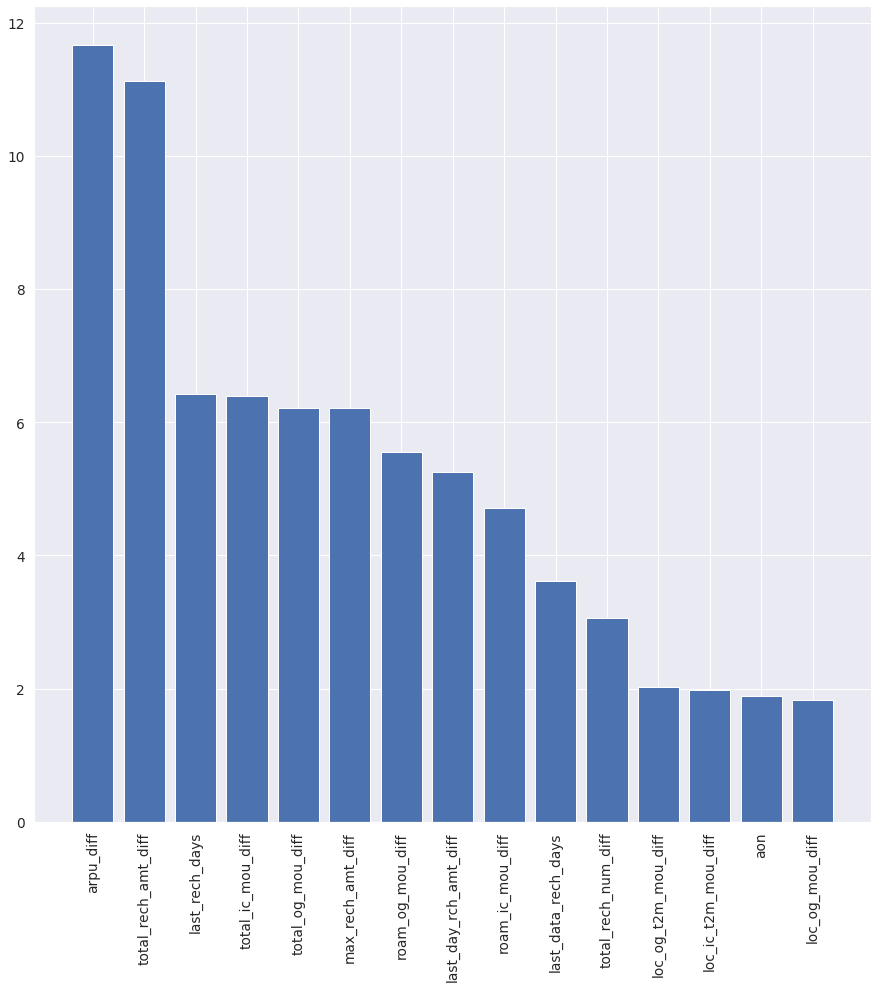

In [ ]:
# extract top '15' features

plt.figure(figsize=(15,15))
plt.bar(feature_importance.variables[0:15],feature_importance.importance[0:15])
plt.xticks(rotation=90)
plt.show()

## Recomendations
- arpu_diff is the avg revenue per user, if the arpu is less for any customer there can be a possibility for customer to churn. The company can provide special offers to retain the customer which inturn will also increase the arpu
- total recharge amt for any customer is less then the customer is most likely to churn. Company can offer special discounts & offers to attract the customer
-last recharge days should be low depending on the recharge validity too for a customer to not churn . The team should keep a note of this and provide them with more talk time offers if it is high 
- same goes for last data recharge too, it should also be less and if not then provide with offers like discount on OTT platforms
- if the values in total incoming & outgoing diff for local as well as roaming drops it can signify churn, may provide with better STD,ISD charges
- the aon- age on network can be a a sign of loyalty the more the better, we should not lose long term customers & retain by offering benifits